In [1]:
import pandas as pd
from datasets import load_dataset
from PIL import Image
import numpy as np
import time
import openai
import os

In [2]:

dataset = load_dataset('poloclub/diffusiondb', 'large_first_1k', trust_remote_code=True)
df=pd.DataFrame(dataset)
df.head()

,train
0,{'image': <PIL.WebPImagePlugin.WebPImageFile i...
1,{'image': <PIL.WebPImagePlugin.WebPImageFile i...
2,{'image': <PIL.WebPImagePlugin.WebPImageFile i...
3,{'image': <PIL.WebPImagePlugin.WebPImageFile i...
4,{'image': <PIL.WebPImagePlugin.WebPImageFile i...


In [3]:

dataset = load_dataset('poloclub/diffusiondb', 'large_first_50k', trust_remote_code=True)




In [4]:

batch_size = 10000
df_list = [] 

for i in range(0, len(dataset['train']), batch_size):
    batch = dataset['train'].select(range(i, min(i + batch_size, len(dataset['train']))))
    df_batch = batch.to_pandas()
    df_list.append(df_batch) 

prompts = pd.concat(df_list, ignore_index=True)
secdeset = pd.read_csv('diffusion_db_unaltered.csv')
prompts = pd.concat([prompts, secdeset], ignore_index=True)

prompts.info()
prompts.head()
prompts.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050000 entries, 0 to 2049999
Data columns (total 12 columns):
 #   Column       Dtype              
---  ------       -----              
 0   image        object             
 1   prompt       object             
 2   seed         float64            
 3   step         float64            
 4   cfg          float32            
 5   sampler      object             
 6   width        float64            
 7   height       float64            
 8   user_name    object             
 9   timestamp    datetime64[us, UTC]
 10  image_nsfw   float64            
 11  prompt_nsfw  float64            
dtypes: datetime64[us, UTC](1), float32(1), float64(6), object(4)
memory usage: 179.9+ MB


,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
2049995,NaN,david bowie giving a piggy back ride to ziggy ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.152736,0.022676
2049996,NaN,david bowie giving a piggy back ride to ziggy ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.127884,0.014115
2049997,NaN,funny computer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.093476,0.000463
2049998,NaN,hilarious witty computing machine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.124379,0.002547
2049999,NaN,"hilarious witty computing machine, lichtenstien",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.044811,0.000964


In [5]:
image_path = prompts.loc[0, 'image']['path'] 
image = Image.open(image_path)
image.show()
image_array = np.array(image)
print(image_array.shape)

(512, 704, 3)


In [6]:
image_rgb = image.convert('RGB')
image_array = np.expand_dims(image_rgb, axis=0)


In [7]:
print(image_array)

[[[[130 154 160]
   [130 153 163]
   [128 154 164]
   ...
   [129 142 160]
   [129 143 163]
   [132 144 158]]

  [[127 152 163]
   [129 154 166]
   [128 153 165]
   ...
   [128 141 162]
   [127 140 163]
   [128 140 164]]

  [[127 152 166]
   [127 153 166]
   [128 155 167]
   ...
   [129 141 162]
   [130 142 163]
   [130 142 162]]

  ...

  [[115  99 120]
   [116  97 123]
   [117  99 125]
   ...
   [123  96 121]
   [124  98 123]
   [122  97 119]]

  [[115  99 121]
   [117  98 124]
   [116  96 123]
   ...
   [123  94 121]
   [122  97 120]
   [124 101 119]]

  [[112  98 116]
   [116  98 123]
   [115  98 124]
   ...
   [121  99 122]
   [118  96 119]
   [121 101 117]]]]


In [8]:
openai.api_key = os.getenv("OPENAI_API_KEY")
import getpass
if openai.api_key is None:
    print(' ValueError("API key is missing. Please set the OPENAI_API_KEY environment variable.")')
    openai.api_key = getpass.getpass("Enter your API key: ")
client = openai

In [46]:
def classify_word(word):
    prompt = f"Classify the word '{word}' into one of the following categories: 'illegal', 'explicit', 'violent', 'innocent'. Provide just the category as the output. Ensure one of these categories is no matter what stated."

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies words."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10
        )
        
        classification = response.choices[0].message.content.strip()
        if 'illegal' in classification:
            classification = 'illegal'
        elif 'explicit' in classification:
            classification = 'explicit'
        elif 'violent' in classification:
            classification = 'violent'
        elif 'innocent' in classification:
            classification = 'innocent'
        else:
            response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies words."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=30
        )
        category_mapping = {
            "illegal": 1,
            "explicit": 2,
            "violent": 3,
            "innocent": 0
        }
        
        return category_mapping.get(classification, -1) 
    
    except Exception as e:
        print(f"Error classifying word '{word}': {e}")
        return -1

In [10]:
import re

def numberify(word):
    prompt = f"HERE IS THE WORD: {word}"

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": """Assign the word a number based on the following criteria.
    The number will be 4 digits. The first 4 digits determine how 'bad' the word may be.
    - Filler words = 1111
    - Non-explicit subjects = 2222
    - Non-explicit verbs = 3333
    - Explicit words increase progressively (e.g., 5555, 6666, 7777, 8888)
    - Use 9999 only for extreme cases.
    Respond with just the number!."""},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10
        )
        classification = response.choices[0].message.content.strip()

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": """Assign the word a number from 00 to 99 based on severity.
    - Use a balanced scale with 99 reserved for extreme words.
    Respond with just the number!."""},
                {"role": "user", "content": prompt}
            ],
            max_tokens=10
        )
        secondary = response.choices[0].message.content.strip()

        letter_count = len(re.findall(r'[a-zA-Z]', word))
        formatted_count = str(letter_count).zfill(2) 

        final_number = f"{classification}{formatted_count}{secondary}"

        return final_number, word 
    
    except Exception as e:
        print(f"Error classifying word '{word}': {e}")
        return -1, word  


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   train   1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [12]:
"""
import re
from tqdm import tqdm

# Example DataFrame (replace this with your actual DataFrame)

word_classifications = {}
rows = []
words_set = set()
# Loop through the DataFrame and classify words across all rows
for idx, row in tqdm(prompts.iterrows(), total=len(prompts), desc="Processing prompts"):
    prompt = row['prompt']
    for word in re.findall(r'\b\w+\b', prompt):  # Split the prompt into individual words
        if word not in words_set:  # Avoid classifying the same word twice
            words_set.add(word)
            word_classifications[word] = {}
            classification_value = classify_word(word)
            numeric_value, interpreted_word=numberify(word)
            rows.append([word, classification_value, numeric_value, interpreted_word])
            print(word, classification_value, numeric_value, interpreted_word)
        # Sleep to avoid hitting API rate limits
        time.sleep(.1)  # Adjust the sleep time as necessary

# Convert the dictionary to a DataFrame for better visualization
word_classification_df = pd.DataFrame(rows, columns=["Word", "Classification", "Number", "NumericInterpretedWord"])
# Display the final DataFrame with words and their classifications
print(word_classification_df)
"""

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\georg\AppData\Local\Temp\ipykernel_4256\89643881.py:1: SyntaxWarning: invalid escape sequence '\w'
  """


'\nimport re\nfrom tqdm import tqdm\n\n# Example DataFrame (replace this with your actual DataFrame)\n\nword_classifications = {}\nrows = []\nwords_set = set()\n# Loop through the DataFrame and classify words across all rows\nfor idx, row in tqdm(prompts.iterrows(), total=len(prompts), desc="Processing prompts"):\n    prompt = row[\'prompt\']\n    for word in re.findall(r\'\x08\\w+\x08\', prompt):  # Split the prompt into individual words\n        if word not in words_set:  # Avoid classifying the same word twice\n            words_set.add(word)\n            word_classifications[word] = {}\n            classification_value = classify_word(word)\n            numeric_value, interpreted_word=numberify(word)\n            rows.append([word, classification_value, numeric_value, interpreted_word])\n            print(word, classification_value, numeric_value, interpreted_word)\n        # Sleep to avoid hitting API rate limits\n        time.sleep(.1)  # Adjust the sleep time as necessary\n\n# C

In [178]:
import re
import pandas as pd
from tqdm import tqdm
from collections import OrderedDict

def normalize_text(text):
    replacements = {
        '3': 'E', '5': 'S', '0': 'O', '1': 'I', '2': 'Z'
    }
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text

ordered_words = OrderedDict()
prompts['prompt'] = prompts['prompt'].fillna("").astype(str)

try:
    df=pd.read_csv('Wordlist.csv')
except:
    for prompt in tqdm(prompts['prompt'], desc="Extracting unique words"):
        prompt = normalize_text(prompt)
        words = re.findall(r'\b\w+\b', prompt)
        for word in words:
            if word not in ordered_words: 
                ordered_words[word] = None  
    
    rows = []
    for word in tqdm(ordered_words.keys(), desc="Classifying words"):
        classification_value = classify_word(word)
        numeric_value, interpreted_word = numberify(word)
        rows.append([word, classification_value, numeric_value, interpreted_word])
    
    df = pd.DataFrame(rows, columns=["Word", "Classification", "Number", "NumericInterpretedWord"])

print(df)

            Word  Classification    Number NumericInterpretedWord
0        goddess               0  22220715                goddess
1       portrait               0  22220810               portrait
2         ismail               0  22220600                 ismail
3       inceoglu               0  11110800               inceoglu
4             of               0  11110200                     of
...          ...             ...       ...                    ...
196206     anjoy               0  11110520                  anjoy
196207   whylene               0  22220715                whylene
196208  brnjamin               0  11110800               brnjamin
196209   galeano               0  22220725                galeano
196210     nroll               0  33330520                  nroll

[196211 rows x 4 columns]


In [54]:
valid_rows = []
for word in tqdm(ordered_words.keys(), desc="Validating words"):
    existing_row = next((row for row in rows if row[0] == word), None)

    if existing_row:
        classification_value = existing_row[1]  
        numeric_value = existing_row[2]     
        interpreted_word = existing_row[3]

        if classification_value == -1:
            classification_value = classify_word(word)
        if numeric_value == -1:
            numeric_value, interpreted_word = numberify(word)

    else: 
        classification_value = classify_word(word)
        numeric_value, interpreted_word = numberify(word)

    valid_rows.append([word, classification_value, numeric_value, interpreted_word])


df = pd.DataFrame(valid_rows, columns=["Word", "Classification", "Number", "NumericInterpretedWord"])

Validating words: 100%|██████████| 196211/196211 [47:34<00:00, 68.73it/s]  


In [60]:
print(df['Classification'].unique())

[ 0  3  1  2 -1]


In [59]:
df = pd.DataFrame(rows, columns=["Word", "Classification", "Number", "NumericInterpretedWord"])
df.info

<bound method DataFrame.info of             Word  Classification    Number NumericInterpretedWord
0        goddess               0  22220715                goddess
1       portrait               0  22220810               portrait
2         ismail               0  22220600                 ismail
3       inceoglu               0  11110800               inceoglu
4             of               0  11110200                     of
...          ...             ...       ...                    ...
196206     anjoy               0  11110520                  anjoy
196207   whylene               0  22220715                whylene
196208  brnjamin               0  11110800               brnjamin
196209   galeano               0  22220725                galeano
196210     nroll               0  33330520                  nroll

[196211 rows x 4 columns]>

In [67]:
def classify_wordSPECIALIZED(word):
    prompt = f"Classify the word '{word}' into one of the following categories: 'illegal', 'explicit', 'violent', 'innocent'. Provide just the category as the output. Ensure one of these categories is no matter what stated."

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies words."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=50
        )
        
        classification = response.choices[0].message.content.strip()
        print(classification)
        if 'illegal' in classification:
            classification = 'illegal'
        elif 'explicit' in classification:
            classification = 'explicit'
        elif 'violent' in classification:
            classification = 'violent'
        elif 'innocent' in classification:
            classification = 'innocent'
        else:
            response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that classifies words."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=30
        )
            classification = response.choices[0].message.content.strip()
            print(classification)
            if 'illegal' in classification:
                classification = 'illegal'
            elif 'explicit' in classification:
                classification = 'explicit'
            elif 'violent' in classification:
                classification = 'violent'
            elif 'innocent' in classification:
                classification = 'innocent'
        category_mapping = {
            "illegal": 1,
            "explicit": 2,
            "violent": 3,
            "innocent": 0
        }
        
        return category_mapping.get(classification, -1)  # Return -1 for unknown categories
    
    except Exception as e:
        print(f"Error classifying word '{word}': {e}")
        return -1

In [68]:
for index, row in tqdm(df.iterrows(), total=len(df), desc="Validating words"):
    classification_value = row["Classification"]
    numeric_value = row["Number"]

    if classification_value == -1:
        df.at[index, "Classification"] = classify_wordSPECIALIZED(row["Word"])
    if numeric_value == -1:
        df.at[index, "Number"], df.at[index, "NumericInterpretedWord"] = numberify(row["Word"])

Validating words:  21%|██        | 40595/196211 [00:02<00:13, 11761.46it/s]

explicit


Validating words:  23%|██▎       | 45902/196211 [00:03<00:16, 9332.03it/s] 

innocent
innocent
explicit
illegal


Validating words:  24%|██▍       | 47814/196211 [00:07<01:31, 1625.24it/s]

explicit


Validating words:  25%|██▌       | 49165/196211 [00:08<01:27, 1685.04it/s]

innocent
explicit
explicit


Validating words:  26%|██▌       | 50171/196211 [00:10<02:04, 1176.63it/s]

explicit
innocent
explicit


Validating words:  26%|██▌       | 50889/196211 [00:12<02:46, 872.43it/s] 

'innocent'


Validating words:  26%|██▌       | 51402/196211 [00:12<02:39, 908.51it/s]

explicit


Validating words:  26%|██▋       | 51799/196211 [00:13<02:45, 869.98it/s]

illegal


Validating words:  27%|██▋       | 52097/196211 [00:13<02:54, 826.94it/s]

innocent


Validating words:  27%|██▋       | 52395/196211 [00:14<03:04, 779.25it/s]

innocent


Validating words:  27%|██▋       | 53094/196211 [00:14<02:32, 940.47it/s]

explicit


Validating words:  27%|██▋       | 53267/196211 [00:15<02:54, 818.24it/s]

innocent


Validating words:  28%|██▊       | 54340/196211 [00:16<02:16, 1036.25it/s]

explicit


Validating words:  28%|██▊       | 54904/196211 [00:16<02:08, 1100.69it/s]

innocent


Validating words:  28%|██▊       | 55426/196211 [00:16<02:14, 1045.68it/s]

explicit


Validating words:  29%|██▊       | 56356/196211 [00:17<01:49, 1276.54it/s]

illegal


Validating words:  30%|██▉       | 58606/196211 [00:17<01:03, 2181.10it/s]

violent


Validating words:  30%|███       | 59133/196211 [00:18<01:11, 1916.79it/s]

explicit


Validating words:  30%|███       | 59334/196211 [00:18<01:31, 1500.78it/s]

explicit


Validating words:  31%|███       | 60311/196211 [00:23<04:35, 493.84it/s] 

innocent


Validating words:  32%|███▏      | 62031/196211 [00:24<02:34, 871.18it/s]

explicit


Validating words:  32%|███▏      | 62498/196211 [00:25<03:39, 608.38it/s]

None of the categories apply directly to 'illogical'; however, if I must choose one, I would classify it under 'innocent'.
Illegal


Validating words:  33%|███▎      | 64095/196211 [00:28<03:15, 674.22it/s]

illegal


Validating words:  33%|███▎      | 64560/196211 [00:28<03:07, 702.67it/s]

innocent


Validating words:  34%|███▍      | 66231/196211 [00:29<01:46, 1216.83it/s]

illegal


Validating words:  35%|███▍      | 68383/196211 [00:31<02:01, 1055.67it/s]

None of the provided categories accurately fit the word 'imperious'. However, if I must classify it, the closest would be 'explicit', as it can describe a commanding or overbearing attitude, though it's not explicit in a vulgar sense.


Validating words:  37%|███▋      | 72837/196211 [00:33<00:58, 2114.67it/s]

innocent


Validating words:  39%|███▉      | 76214/196211 [00:34<01:03, 1893.81it/s]

innocent


Validating words:  39%|███▉      | 76701/196211 [00:35<01:39, 1196.81it/s]

innocent
innocent


Validating words:  39%|███▉      | 77059/196211 [00:37<03:30, 565.43it/s] 

innocent


Validating words:  40%|███▉      | 77540/196211 [00:38<03:35, 550.46it/s]

innocent


Validating words:  40%|███▉      | 78339/196211 [00:39<02:30, 784.00it/s]

innocent


Validating words:  40%|████      | 78623/196211 [00:39<03:14, 603.41it/s]

innocent


Validating words:  40%|████      | 78940/196211 [00:40<03:49, 511.35it/s]

innocent


Validating words:  40%|████      | 79097/196211 [00:41<04:15, 458.72it/s]

innocent


Validating words:  40%|████      | 79374/196211 [00:41<04:03, 480.50it/s]

violent


Validating words:  41%|████      | 79635/196211 [00:42<04:37, 420.55it/s]

innocent


Validating words:  41%|████      | 79763/196211 [00:43<06:44, 288.20it/s]

None of the categories accurately apply to 'Hideous', but if I had to choose one, it would be 'explicit'.


Validating words:  41%|████      | 80694/196211 [00:45<03:34, 538.38it/s]

'Sinister' can be classified into the category: 'violent'.
violent
explicit


Validating words:  41%|████      | 80914/196211 [00:47<07:19, 262.50it/s]

innocent


Validating words:  41%|████▏     | 81071/196211 [00:48<08:23, 228.78it/s]

innocent


Validating words:  42%|████▏     | 82211/196211 [00:49<03:00, 630.82it/s]

innocent


Validating words:  42%|████▏     | 83118/196211 [00:49<01:53, 998.53it/s]

illegal


Validating words:  43%|████▎     | 83559/196211 [00:50<02:32, 739.82it/s]

innocent


Validating words:  43%|████▎     | 84420/196211 [00:51<01:50, 1008.24it/s]

illegal


Validating words:  44%|████▎     | 85710/196211 [00:52<01:08, 1618.89it/s]

innocent


Validating words:  45%|████▌     | 88357/196211 [00:52<00:26, 4018.74it/s]

innocent
innocent


Validating words:  45%|████▌     | 89042/196211 [00:54<02:01, 879.72it/s] 

violent
violent
illegal


Validating words:  46%|████▌     | 89530/196211 [00:56<03:04, 579.69it/s]

innocent


Validating words:  46%|████▌     | 89965/196211 [00:57<03:01, 586.63it/s]

innocent


Validating words:  46%|████▋     | 91011/196211 [00:58<02:00, 874.36it/s]

innocent


Validating words:  47%|████▋     | 92078/196211 [00:58<01:32, 1122.11it/s]

illegal
innocent


Validating words:  47%|████▋     | 92418/196211 [01:00<02:39, 649.03it/s] 

innocent


Validating words:  48%|████▊     | 93363/196211 [01:00<01:51, 922.78it/s]

innocent


Validating words:  48%|████▊     | 93699/196211 [01:01<02:23, 714.56it/s]

'Authoritarian' can be classified as 'explicit'.


Validating words:  48%|████▊     | 94549/196211 [01:02<01:55, 882.04it/s]

explicit


Validating words:  49%|████▉     | 95722/196211 [01:03<01:42, 976.51it/s]

None of the categories accurately fit the word 'Arrogant'. However, based on the listed options, I will categorize it as follows:

'innocent'


Validating words:  49%|████▉     | 96671/196211 [01:04<01:31, 1087.69it/s]

innocent


Validating words:  50%|████▉     | 97643/196211 [01:05<01:15, 1303.61it/s]

'disgrace' - innocent


Validating words:  50%|█████     | 98753/196211 [01:06<01:21, 1192.79it/s]

innocent


Validating words:  51%|█████     | 99551/196211 [01:07<01:28, 1096.49it/s]

innocent


Validating words:  51%|█████     | 100488/196211 [01:08<01:25, 1114.62it/s]

innocent


Validating words:  54%|█████▍    | 105640/196211 [01:09<00:41, 2164.78it/s]

innocent
None


Validating words:  54%|█████▍    | 106334/196211 [01:11<01:27, 1023.33it/s]

None of the categories apply to 'inferior'.


Validating words:  55%|█████▍    | 107342/196211 [01:12<01:09, 1286.80it/s]

'Perdition' can be classified as 'violent'.


Validating words:  56%|█████▌    | 110061/196211 [01:13<00:38, 2242.95it/s]

illegal


Validating words:  57%|█████▋    | 111418/196211 [01:14<00:45, 1845.65it/s]

innocent
explicit


Validating words:  57%|█████▋    | 111934/196211 [01:16<02:04, 677.86it/s] 

innocent


Validating words:  58%|█████▊    | 113292/196211 [01:17<01:16, 1081.11it/s]

explicit


Validating words:  58%|█████▊    | 114546/196211 [01:17<00:44, 1845.46it/s]

explicit


Validating words:  59%|█████▉    | 116014/196211 [01:19<01:22, 968.02it/s] 

violent


Validating words:  59%|█████▉    | 116556/196211 [01:21<01:41, 785.13it/s]

explicit


Validating words:  60%|█████▉    | 116950/196211 [01:21<01:44, 761.96it/s]

innocent


Validating words:  60%|██████    | 118312/196211 [01:23<01:29, 867.08it/s]

innocent


Validating words:  62%|██████▏   | 121033/196211 [01:24<00:35, 2113.85it/s]

explicit


Validating words:  62%|██████▏   | 122366/196211 [01:24<00:34, 2110.62it/s]

explicit


Validating words:  63%|██████▎   | 123540/196211 [01:25<00:31, 2309.65it/s]

innocent


Validating words:  63%|██████▎   | 124555/196211 [01:25<00:35, 1992.77it/s]

'innocent'


Validating words:  64%|██████▎   | 124989/196211 [01:26<01:04, 1109.07it/s]

innocent


Validating words:  64%|██████▍   | 125293/196211 [01:27<01:14, 949.79it/s] 

explicit


Validating words:  64%|██████▍   | 125628/196211 [01:27<01:19, 893.36it/s]

violent


Validating words:  64%|██████▍   | 126186/196211 [01:28<01:18, 889.41it/s]

explicit
innocent


Validating words:  65%|██████▌   | 127664/196211 [01:29<00:46, 1487.07it/s]

explicit


Validating words:  66%|██████▌   | 129207/196211 [01:30<00:32, 2074.18it/s]

explicit


Validating words:  66%|██████▋   | 130367/196211 [01:30<00:31, 2079.50it/s]

explicit


Validating words:  67%|██████▋   | 132171/196211 [01:31<00:26, 2432.27it/s]

innocent


Validating words:  69%|██████▉   | 135611/196211 [01:32<00:27, 2223.12it/s]

innocent


Validating words:  69%|██████▉   | 136152/196211 [01:33<00:37, 1606.54it/s]

illegal


Validating words:  70%|██████▉   | 137177/196211 [01:34<00:36, 1609.10it/s]

innocent


Validating words:  70%|███████   | 137788/196211 [01:34<00:28, 2075.19it/s]

innocent
innocent


Validating words:  71%|███████   | 138884/196211 [01:36<01:09, 821.50it/s] 

'oppositional' falls into the category 'explicit'.
Please provide a word for classification.


Validating words:  71%|███████▏  | 139936/196211 [01:38<01:09, 814.95it/s]

Please provide the word you want me to classify.


Validating words:  73%|███████▎  | 142775/196211 [01:39<00:26, 2028.04it/s]

violent


Validating words:  73%|███████▎  | 143224/196211 [01:39<00:34, 1531.00it/s]

illegal
'vitriol' typically refers to cruel and bitter criticism or remarks, which can be associated with a violent tone in language. Therefore, the category is:

violent
innocent


Validating words:  73%|███████▎  | 143563/196211 [01:42<01:31, 572.55it/s] 

'violent'


Validating words:  73%|███████▎  | 143920/196211 [01:43<01:47, 484.32it/s]

innocent


Validating words:  74%|███████▍  | 144931/196211 [01:44<01:07, 760.68it/s]

explicit


Validating words:  76%|███████▌  | 148187/196211 [01:45<00:20, 2297.73it/s]

innocent


Validating words:  76%|███████▌  | 148707/196211 [01:45<00:23, 1995.53it/s]

explicit


Validating words:  76%|███████▌  | 149478/196211 [01:45<00:27, 1708.26it/s]

innocent


Validating words:  77%|███████▋  | 150583/196211 [01:46<00:23, 1981.36it/s]

innocent


Validating words:  77%|███████▋  | 151722/196211 [01:47<00:25, 1764.36it/s]

explicit


Validating words:  78%|███████▊  | 152599/196211 [01:47<00:27, 1587.45it/s]

innocent


Validating words:  79%|███████▉  | 154674/196211 [01:48<00:17, 2383.94it/s]

illegal


Validating words:  79%|███████▉  | 155741/196211 [01:49<00:18, 2170.50it/s]

innocent


Validating words:  80%|███████▉  | 156167/196211 [01:49<00:24, 1631.46it/s]

explicit


Validating words:  80%|███████▉  | 156623/196211 [01:50<00:31, 1244.94it/s]

innocent
innocent


Validating words:  80%|████████  | 157127/196211 [01:52<01:06, 589.26it/s] 

innocent


Validating words:  80%|████████  | 157870/196211 [01:54<01:25, 448.73it/s]

innocent


Validating words:  81%|████████  | 158128/196211 [01:55<01:26, 441.97it/s]

innocent


Validating words:  81%|████████  | 159195/196211 [01:56<00:47, 783.97it/s]

'Radical' can be classified as 'violent'.


Validating words:  82%|████████▏ | 160338/196211 [01:56<00:27, 1290.40it/s]

explicit


Validating words:  83%|████████▎ | 162783/196211 [01:57<00:16, 2004.86it/s]

innocent


Validating words:  84%|████████▍ | 164457/196211 [01:58<00:13, 2395.62it/s]

innocent


Validating words:  84%|████████▍ | 164968/196211 [01:59<00:24, 1274.38it/s]

violent
innocent


Validating words:  84%|████████▍ | 165284/196211 [02:00<00:42, 723.83it/s] 

innocent


Validating words:  84%|████████▍ | 165514/196211 [02:01<00:54, 561.98it/s]

'innocent'


Validating words:  85%|████████▍ | 165907/196211 [02:02<00:56, 534.54it/s]

innocent


Validating words:  85%|████████▍ | 166747/196211 [02:02<00:39, 752.05it/s]

illegal


Validating words:  85%|████████▌ | 167596/196211 [02:03<00:28, 990.25it/s]

innocent


Validating words:  86%|████████▋ | 169243/196211 [02:04<00:22, 1189.60it/s]

illegal
none


Validating words:  87%|████████▋ | 170116/196211 [02:05<00:26, 981.96it/s] 

innocent


Validating words:  87%|████████▋ | 170548/196211 [02:06<00:33, 758.98it/s]

innocent


Validating words:  87%|████████▋ | 170793/196211 [02:07<00:47, 538.36it/s]

'Despised' falls under the category 'innocent'.


Validating words:  87%|████████▋ | 170972/196211 [02:08<00:52, 478.65it/s]

explicit


Validating words:  88%|████████▊ | 172593/196211 [02:09<00:20, 1128.70it/s]

explicit


Validating words:  89%|████████▊ | 173820/196211 [02:09<00:11, 1987.31it/s]

Please provide the word you would like classified.


Validating words:  89%|████████▉ | 174897/196211 [02:11<00:19, 1112.27it/s]

innocent


Validating words:  90%|█████████ | 176841/196211 [02:12<00:12, 1601.61it/s]

illegal


Validating words:  91%|█████████ | 178470/196211 [02:12<00:05, 3009.55it/s]

illegal
innocent


Validating words:  91%|█████████▏| 179126/196211 [02:14<00:17, 978.44it/s] 

innocent


Validating words:  92%|█████████▏| 180209/196211 [02:15<00:15, 1031.10it/s]

'violent'


Validating words:  92%|█████████▏| 180632/196211 [02:15<00:16, 920.77it/s] 

'Draconian' fits best into the category: 'violent'.
innocent


Validating words:  93%|█████████▎| 181631/196211 [02:17<00:16, 895.72it/s]

innocent


Validating words:  96%|█████████▌| 187598/196211 [02:18<00:01, 5330.17it/s]

explicit
innocent


Validating words:  96%|█████████▋| 188892/196211 [02:20<00:05, 1379.09it/s]

innocent


Validating words:  97%|█████████▋| 190142/196211 [02:20<00:02, 2223.48it/s]

Illegal


Validating words:  97%|█████████▋| 190743/196211 [02:21<00:05, 955.52it/s] 

Illegal


Validating words:  97%|█████████▋| 191158/196211 [02:22<00:06, 834.42it/s]

illegal


Validating words:  98%|█████████▊| 192021/196211 [02:23<00:04, 933.64it/s]

explicit
none


Validating words:  99%|█████████▊| 193526/196211 [02:24<00:02, 1337.68it/s]

innocent


Validating words:  99%|█████████▉| 193940/196211 [02:25<00:02, 1023.48it/s]

illegal


Validating words:  99%|█████████▉| 194945/196211 [02:26<00:00, 1472.23it/s]

explicit


Validating words: 100%|██████████| 196211/196211 [02:26<00:00, 1342.42it/s]


In [136]:
print(df.loc[df['Classification'] == -1])

Empty DataFrame
Columns: [Word, Classification, Number, NumericInterpretedWord]
Index: []


In [137]:
df.loc[df['Classification'] == -1, 'Classification'] = 0

In [138]:
len(df)

196211

In [139]:
count_class_1 = len(df.loc[df['Classification'] == 1])
count_class_2 = len(df.loc[df['Classification'] == 2])
count_class_3 = len(df.loc[df['Classification'] == 3])

print(f"Count of Classification 1: {count_class_1}")
print(f"Count of Classification 2: {count_class_2}")
print(f"Count of Classification 3: {count_class_3}")

Count of Classification 1: 2991
Count of Classification 2: 2084
Count of Classification 3: 3944


In [140]:
print(df.loc[df['Classification'] == 2])

             Word  Classification    Number NumericInterpretedWord
130      detailed               2  33330840               detailed
136        rapper               2  22220610                 rapper
391         scumm               2  88880587                  scumm
468         dirty               2  66660530                  dirty
604     seductive               2  33330945              seductive
...           ...             ...       ...                    ...
195932   fartgerm               2  66660825               fartgerm
195973       fugg               2  99990450                   fugg
195988  copulated               2  66660930              copulated
196009   headhead               2  11110805               headhead
196204   hellcave               2  66660845               hellcave

[2084 rows x 4 columns]


In [86]:
df.to_csv('WordList.csv', index=False)


In [87]:
"""
Conditions: combination of 2 or more illicit classifications 1+2, 2+3, 1+3
Repetition: 3 or more repitions of the same illicit classification
average of numbers: if the average number is over 50000000
High number: If there is any instance of a number over 60000000
"""

'\nConditions: combination of 2 or more illicit classifications 1+2, 2+3, 1+3\nRepetition: 3 or more repitions of the same illicit classification\naverage of numbers: if the average number is over 50000000\nHigh number: If there is any instance of a number over 60000000\n'

In [88]:
SafePrompt='Generate an image of a child looking to the starry night'
NSFWPrompt='Generate an image of a busty looking female with big boobs'

In [89]:
prompts.head()

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,allowed,Classprompt,Numprompt
0,"{'bytes': None, 'path': 'C:\Users\georg\.cache...","goddess portrait, ismail inceoglu",9.119600e+08,50.0,10.0,k_lms,704.0,512.0,d4393f4711a09b71abe9ac39a849b68d70f88ad15b94b0...,2022-08-20 09:32:00+00:00,0.055936,0.007284,1,0 0 0 0,22220725 22220825 22220600 11110800
1,"{'bytes': None, 'path': 'C:\Users\georg\.cache...","goddess portrait, ismail inceoglu",3.614154e+09,50.0,10.0,k_lms,704.0,512.0,d4393f4711a09b71abe9ac39a849b68d70f88ad15b94b0...,2022-08-20 09:32:00+00:00,0.103962,0.007284,1,0 0 0 0,22220730 22220810 22220600 11110800
2,"{'bytes': None, 'path': 'C:\Users\georg\.cache...",portrait of king of candy mr harry haribo oil ...,2.271109e+09,50.0,7.0,k_lms,512.0,512.0,7c375c633f3ac3961453837abde94580b043b1c2eb5abc...,2022-08-20 09:33:00+00:00,0.034399,0.022897,1,0 0 0 0 0 0 0 0 0 0 3 3 0 0,22220825 11110200 22220410 11110200 22220505 1...
3,"{'bytes': None, 'path': 'C:\Users\georg\.cache...",super epic realistic nature photo trending on ...,1.947975e+09,50.0,7.0,k_lms,832.0,1024.0,bd227929e003e69eee392c1d8a409445dd790455c1e9bd...,2022-08-20 09:34:00+00:00,0.113144,0.001688,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,33330530 22220475 22220945 22220625 22220510 3...
4,"{'bytes': None, 'path': 'C:\Users\georg\.cache...",super epic realistic nature photo trending on ...,1.035761e+09,50.0,7.0,k_lms,832.0,1024.0,bd227929e003e69eee392c1d8a409445dd790455c1e9bd...,2022-08-20 09:34:00+00:00,0.096025,0.001688,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,22220545 22220475 22220942 22220625 22220510 3...


In [134]:
prompts['allowed'] = (prompts['prompt_nsfw'] < 0.5).astype(int)

In [135]:
prompts.head()

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,allowed,Classprompt,Numprompt,Class 3 appearance count,Class 2 appearance count,Class 1 appearance count,Class Sum count,Guess allowed,Numbers,Average Number,Banned
0,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\f396d2d6-0668-46d6-833c-6a7da4c1038b.webp'}","goddess portrait, ismail inceoglu",9.119600e+08,50.0,10.0,k_lms,704.0,512.0,d4393f4711a09b71abe9ac39a849b68d70f88ad15b94b0f0b554571bee4e6741,2022-08-20 09:32:00+00:00,0.055936,0.007284,1,0 0 0 0,22220715 22220810 22220600 11110800,0.0,0.0,0.0,0.0,1.0,"[22220715, 22220810, 22220600, 11110800]",1.944323e+07,0
1,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\941d339b-5481-4ee2-b92d-d8a8d2cbfc50.webp'}","goddess portrait, ismail inceoglu",3.614154e+09,50.0,10.0,k_lms,704.0,512.0,d4393f4711a09b71abe9ac39a849b68d70f88ad15b94b0f0b554571bee4e6741,2022-08-20 09:32:00+00:00,0.103962,0.007284,1,0 0 0 0,22220715 22220810 22220600 11110800,0.0,0.0,0.0,0.0,1.0,"[22220715, 22220810, 22220600, 11110800]",1.944323e+07,0
2,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\411fd6fe-8b57-430a-a8f6-60d51a8085d1.webp'}",portrait of king of candy mr harry haribo oil painting bloody conquest tap [ e,2.271109e+09,50.0,7.0,k_lms,512.0,512.0,7c375c633f3ac3961453837abde94580b043b1c2eb5abce4d2c609650b08f08b,2022-08-20 09:33:00+00:00,0.034399,0.022897,1,0 0 0 0 0 0 0 0 0 0 3 3 0 0,22220810 11110200 22220425 11110200 22220510 11110200 33330510 22220600 22220320 22220810 66660675 22220845 33330310 11110100,2.0,0.0,0.0,2.0,0.0,"[22220810, 11110200, 22220425, 11110200, 22220510, 11110200, 33330510, 22220600, 22220320, 22220810, 66660675, 22220845, 33330310, 11110100]",2.380761e+07,0
3,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\6f169011-9809-48a6-9b48-cad6cb07e37f.webp'}",super epic realistic nature photo trending on instagram with lonely person in yellow raincoat standing at a distance,1.947975e+09,50.0,7.0,k_lms,832.0,1024.0,bd227929e003e69eee392c1d8a409445dd790455c1e9bd86ae9e32f4341a874f,2022-08-20 09:34:00+00:00,0.113144,0.001688,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,33330545 22220475 22220945 22220630 22220510 33330825 33330201 22220925 11110410 22220625 22220650 11110200 22220620 22220810 33330825 11110200 11110100 22220825,0.0,0.0,0.0,0.0,1.0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]",2.222057e+07,0
4,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\f88c16f5-5c8c-4427-b50e-2f155204eb11.webp'}",super epic realistic nature photo trending on instagram with lonely person in yellow raincoat standing at a distance,1.035761e+09,50.0,7.0,k_lms,832.0,1024.0,bd227929e003e69eee392c1d8a409445dd790455c1e9bd86ae9e32f4341a874f,2022-08-20 09:34:00+00:00,0.096025,0.001688,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,33330545 22220475 22220945 22220630 22220510 33330825 33330201 22220925 11110410 22220625 22220650 11110200 22220620 22220810 33330825 11110200 11110100 22220825,0.0,0.0,0.0,0.0,1.0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]",2.222057e+07,0


In [92]:
print(prompts['allowed'].unique())

[1 0]


In [93]:
prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050000 entries, 0 to 2049999
Data columns (total 15 columns):
 #   Column       Dtype              
---  ------       -----              
 0   image        object             
 1   prompt       object             
 2   seed         float64            
 3   step         float64            
 4   cfg          float32            
 5   sampler      object             
 6   width        float64            
 7   height       float64            
 8   user_name    object             
 9   timestamp    datetime64[us, UTC]
 10  image_nsfw   float64            
 11  prompt_nsfw  float64            
 12  allowed      int32              
 13  Classprompt  object             
 14  Numprompt    object             
dtypes: datetime64[us, UTC](1), float32(1), float64(6), int32(1), object(6)
memory usage: 219.0+ MB


In [189]:
import re
from tqdm import tqdm
try:
    print('Loading Dataset...')
    prompts = pd.read_csv('df_subset.csv', 
    usecols=['Numbers', 'allowed', 'Classprompt'],
    low_memory=False
)
    print('done')
except:
    df_dict = df.set_index('Word')[['Classification', 'Number']].to_dict(orient='index')

    for idx, row in tqdm(prompts.iterrows(), total=len(prompts), desc="Processing prompts"):
        Classprompt = row['prompt']
        Numprompt = row['prompt']
    
        Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
        Numprompt = re.sub(r'[^a-zA-Z\s]', '', Numprompt) 
        for word in re.findall(r'\b\w+\b', Classprompt):  
            if word in df_dict:
                classification_value = df_dict[word]['Classification']
                numeric_value = df_dict[word]['Number']
            else:
                classification_value = classify_word(word)
                numeric_value, _ = numberify(word)
            Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(classification_value), Classprompt)
            Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(numeric_value), Numprompt)
    
        prompts.at[idx, 'Classprompt'] = str(Classprompt) 
        prompts.at[idx, 'Numprompt'] = str(Numprompt) 


Loading Dataset...
done


In [190]:
prompts.head()

,allowed,Classprompt,Numbers
0,1,0 0 0 0,"[22220715, 22220810, 22220600, 11110800]"
1,1,0 0 0 0,"[22220715, 22220810, 22220600, 11110800]"
2,1,0 0 0 0 0 0 0 0 0 0 3 3 0 0,"[22220810, 11110200, 22220425, 11110200, 22220510, 11110200, 33330510, 22220600, 22220320, 22220810, 66660675, 22220845, 33330310, 11110100]"
3,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]"
4,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]"


In [191]:
prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867760 entries, 0 to 867759
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   allowed      867760 non-null  int64 
 1   Classprompt  867213 non-null  object
 2   Numbers      867760 non-null  object
dtypes: int64(1), object(2)
memory usage: 19.9+ MB


In [196]:
#pre filtering
prompts['Class 3 appearance count'] = prompts['Classprompt'].str.count('3')
prompts['Class 2 appearance count'] = prompts['Classprompt'].str.count('2')
prompts['Class 1 appearance count'] = prompts['Classprompt'].str.count('1')

prompts['Class Sum count'] = (
    prompts['Class 3 appearance count'] +
    prompts['Class 2 appearance count'] +
    prompts['Class 1 appearance count']
)

prompts.loc[prompts['Class 3 appearance count'] > 4, 'Guess allowed'] = 0
prompts.loc[prompts['Class 2 appearance count'] > 4, 'Guess allowed'] = 0
prompts.loc[prompts['Class 1 appearance count'] > 4, 'Guess allowed'] = 0
prompts.loc[prompts['Class Sum count'] > 4, 'Guess allowed'] = 0

prompts['Numbers'] = (
    prompts['Numbers']
    .fillna("")
    .astype(str)
    .str.findall(r'\d+') 
    .apply(lambda x: [int(num) for num in x] if x else []) 
)

prompts['Average Number'] = prompts['Numbers'].apply(lambda x: sum(x)/len(x) if x else 0)
prompts.loc[prompts['Average Number'] > 50000000, 'Guess allowed'] = 0
prompts.loc[prompts['Average Number'] <= 50000000, 'Guess allowed'] = 1

prompts.loc[prompts['Numbers'].apply(lambda x: any(num > 60000000 for num in x)), 'Guess allowed'] = 0

"""
Conditions: combination of 2 or more illicit classifications 1+2, 2+3, 1+3
Repetition: 3 or more repitions of the same illicit classification
average of numbers: if the average number is over 50000000
High number: If there is any instance of a number over 60000000
"""
prompts.head()


,allowed,Classprompt,Numbers,Class 3 appearance count,Class 2 appearance count,Class 1 appearance count,Class Sum count,Guess allowed,Average Number
0,1,0 0 0 0,"[22220715, 22220810, 22220600, 11110800]",0.0,0.0,0.0,0.0,1.0,1.944323e+07
1,1,0 0 0 0,"[22220715, 22220810, 22220600, 11110800]",0.0,0.0,0.0,0.0,1.0,1.944323e+07
2,1,0 0 0 0 0 0 0 0 0 0 3 3 0 0,"[22220810, 11110200, 22220425, 11110200, 22220510, 11110200, 33330510, 22220600, 22220320, 22220810, 66660675, 22220845, 33330310, 11110100]",2.0,0.0,0.0,2.0,0.0,2.380761e+07
3,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]",0.0,0.0,0.0,0.0,1.0,2.222057e+07
4,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]",0.0,0.0,0.0,0.0,1.0,2.222057e+07


In [197]:
"""
df_subset = prompts.head(867760)
df_subset.to_csv('df_subset.csv', index=False)
"""

"\ndf_subset = prompts.head(867760)\ndf_subset.to_csv('df_subset.csv', index=False)\n"

In [198]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
print(prompts.iloc[2])

allowed                                                                                                                                                                1
Classprompt                                                                                                                                0 0 0 0 0 0 0 0 0 0 3 3 0  0 
Numbers                     [22220810, 11110200, 22220425, 11110200, 22220510, 11110200, 33330510, 22220600, 22220320, 22220810, 66660675, 22220845, 33330310, 11110100]
Class 3 appearance count                                                                                                                                             2.0
Class 2 appearance count                                                                                                                                             0.0
Class 1 appearance count                                                                                                                                   

In [199]:
df_subset = prompts.head(867760)
if 'Guess allowed' in df_subset.columns and 'allowed' in df_subset.columns:
    true_positives = (df_subset['Guess allowed'] == 1) & (df_subset['allowed'] == 1)

    true_negatives = (df_subset['Guess allowed'] == 0) & (df_subset['allowed'] == 0)

    false_positives = (df_subset['Guess allowed'] == 1) & (df_subset['allowed'] == 0)

    false_negatives = (df_subset['Guess allowed'] == 0) & (df_subset['allowed'] == 1)

    tp_count = true_positives.sum()
    tn_count = true_negatives.sum()
    fp_count = false_positives.sum()
    fn_count = false_negatives.sum()

    print(f"True Positives (TP): {tp_count}")
    print(f"True Negatives (TN): {tn_count}")
    print(f"False Positives (FP): {fp_count}")
    print(f"False Negatives (FN): {fn_count}")
    total = len(df_subset)

    tp_percentage = (tp_count / total) * 100
    tn_percentage = (tn_count / total) * 100
    fp_percentage = (fp_count / total) * 100
    fn_percentage = (fn_count / total) * 100

    print(f"True Positives Ratio: {tp_percentage:.2f}%")
    print(f"True Negatives Ratio: {tn_percentage:.2f}%")
    print(f"False Positives Ratio: {fp_percentage:.2f}%")
    print(f"False Negatives Ratio: {fn_percentage:.2f}%")

    accuracy = (tp_count + tn_count) / len(df_subset)
    print(f"Accuracy: {accuracy * 100:.2f}%")
else:
    print("The required columns are not present in the first 100 rows.")

True Positives (TP): 789106
True Negatives (TN): 3699
False Positives (FP): 6537
False Negatives (FN): 68418
True Positives Ratio: 90.94%
True Negatives Ratio: 0.43%
False Positives Ratio: 0.75%
False Negatives Ratio: 7.88%
Accuracy: 91.36%


In [200]:
import re
from tqdm import tqdm

custom_prompt = NSFWPrompt

word_classifications = {}
rows = []

Classprompt = custom_prompt
Numprompt = custom_prompt

Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
Numprompt = re.sub(r'[^a-zA-Z\s]', '', Numprompt)

for word in re.findall(r'\b\w+\b', Classprompt):  
    if word not in word_classifications:
        classification_value = classify_word(word) 
        numeric_value, interpreted_word = numberify(word)
        word_classifications[word] = {'Classification': classification_value, 
                                       'Number': numeric_value, 'NumericInterpretedWord': interpreted_word}
    else:
        classification_value = word_classifications[word]['Classification']
        numeric_value = word_classifications[word]['Number']
    
    Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(classification_value), Classprompt)
    Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(numeric_value), Numprompt)

print("Processed Classprompt:", Classprompt)
print("Processed Numprompt:", Numprompt)

Class_3_count = Classprompt.count('3')
Class_2_count = Classprompt.count('2')
Class_1_count = Classprompt.count('1')

Class_Sum_count = Class_3_count + Class_2_count + Class_1_count

Guess_allowed = 1  
if Class_3_count > 4 or Class_2_count > 4 or Class_1_count > 4 or Class_Sum_count > 4:
    Guess_allowed = 0

Numbers = list(map(int, re.findall(r'\d+', Numprompt)))
Average_Number = sum(Numbers)/len(Numbers) if Numbers else 0

if Average_Number > 50000000:
    Guess_allowed = 0
elif any(num > 60000000 for num in Numbers):
    Guess_allowed = 0

print(f"Guess allowed: {Guess_allowed}")

actual_allowed = 0  

if Guess_allowed == actual_allowed:
    print("Prediction is correct.")
else:
    print("Prediction is incorrect.")


Processed Classprompt: 0 0 0 0 0 2 0 0 0 0 2
Processed Numprompt: 33330830 11110200 22220525 11110200 11110100 66660530 33330710 22220610 11110400 22220330 66660525
Guess allowed: 0
Prediction is correct.


In [201]:
import re
from tqdm import tqdm

custom_prompt = SafePrompt

word_classifications = {}
rows = []

Classprompt = custom_prompt
Numprompt = custom_prompt

Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
Numprompt = re.sub(r'[^a-zA-Z\s]', '', Numprompt)

for word in re.findall(r'\b\w+\b', Classprompt):  
    if word not in word_classifications:
        classification_value = classify_word(word) 
        numeric_value, interpreted_word = numberify(word) 
        word_classifications[word] = {'Classification': classification_value, 
                                       'Number': numeric_value, 'NumericInterpretedWord': interpreted_word}
    else:
        classification_value = word_classifications[word]['Classification']
        numeric_value = word_classifications[word]['Number']
    
    Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(classification_value), Classprompt)
    Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(numeric_value), Numprompt)

print("Processed Classprompt:", Classprompt)
print("Processed Numprompt:", Numprompt)

Class_3_count = Classprompt.count('3')
Class_2_count = Classprompt.count('2')
Class_1_count = Classprompt.count('1')

Class_Sum_count = Class_3_count + Class_2_count + Class_1_count

Guess_allowed = 1  
if Class_3_count > 4 or Class_2_count > 4 or Class_1_count > 4 or Class_Sum_count > 4:
    Guess_allowed = 0

Numbers = list(map(int, re.findall(r'\d+', Numprompt)))
Average_Number = sum(Numbers)/len(Numbers) if Numbers else 0

if Average_Number > 50000000:
    Guess_allowed = 0
elif any(num > 60000000 for num in Numbers):
    Guess_allowed = 0

print(f"Guess allowed: {Guess_allowed}")


actual_allowed = 1  

if Guess_allowed == actual_allowed:
    print("Prediction is correct.")
else:
    print("Prediction is incorrect.")


Processed Classprompt: 0 0 0 0 0 0 0 0 0 0 0
Processed Numprompt: 33330810 11110200 22220530 11110200 11110100 22220510 33330725 33330200 11110300 22220610 22220550
Guess allowed: 1
Prediction is correct.


In [202]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [203]:
X = df_subset['Numbers'].apply(lambda x: sum(x) if isinstance(x, list) else 0).values.reshape(-1, 1)
y = df_subset['allowed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
accuracies, precisions, recalls, f1_scores = [], [], [], []
tp_values, tn_values, fp_values, fn_values = [], [], [], []

for k in range(1, 13):
    print("="*50)
    print(f"Results for k={k}")
    print("="*50)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for k={k}: {accuracy * 100:.2f}%')
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for k={k}:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nTrue Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    tp_values.append(tp)
    tn_values.append(tn)
    fp_values.append(fp)
    fn_values.append(fn)
    print(f"Precision for k={k}: {precision * 100:.2f}%")
    print(f"Recall for k={k}: {recall * 100:.2f}%")
    print(f"F1 Score for k={k}: {f1_score * 100:.2f}%")
    
    print("\nFirst 5 predictions vs actual values:")
    for i in range(5):
        print(f"Sample {i+1} - Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}")
    
    print("\n" + "="*50 + "\n")
k_values = list(range(1, 13))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

metrics = [
    (tp_values, "True Positives", "green", "o"),
    (tn_values, "True Negatives", "blue", "s"),
    (fp_values, "False Positives", "red", "^"),
    (fn_values, "False Negatives", "orange", "v"),
    (accuracies, "Accuracy", "purple", "D")
]

for i, (values, title, color, marker) in enumerate(metrics):
    row, col = divmod(i, 2)  
    axes[row, col].plot(k_values, values, marker=marker, linestyle="-", color=color, label=title)
    axes[row, col].set_xlabel("k (Number of Neighbors)")
    axes[row, col].set_ylabel("Count" if title != "Accuracy" else "Score")
    axes[row, col].set_title(f"{title} Across Different k Values")
    axes[row, col].grid(True)
    axes[row, col].legend()

fig.delaxes(axes[2, 1])

plt.subplots_adjust(hspace=0.4)
plt.show()

Results for k=1


KeyboardInterrupt: 

In [204]:
import re
import numpy as np
from tqdm import tqdm


custom_prompt = NSFWPrompt

word_classifications = {}
rows = []

Classprompt = custom_prompt
Numprompt = custom_prompt

Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
Numprompt = re.sub(r'[^a-zA-Z\s]', '', Numprompt)

for word in re.findall(r'\b\w+\b', Classprompt):
    if word not in word_classifications:
        classification_value = classify_word(word)  
        numeric_value, interpreted_word = numberify(word)  
        word_classifications[word] = {'Classification': classification_value, 
                                       'Number': numeric_value, 'NumericInterpretedWord': interpreted_word}
    else:
        classification_value = word_classifications[word]['Classification']
        numeric_value = word_classifications[word]['Number']
    
    Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(classification_value), Classprompt)
    Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(numeric_value), Numprompt)

print("Processed Classprompt:", Classprompt)
print("Processed Numprompt:", Numprompt)

Class_3_count = Classprompt.count('3')
Class_2_count = Classprompt.count('2')
Class_1_count = Classprompt.count('1')

Class_Sum_count = Class_3_count + Class_2_count + Class_1_count

Guess_allowed = 1  
if Class_3_count > 4 or Class_2_count > 4 or Class_1_count > 4 or Class_Sum_count > 4:
    Guess_allowed = 0

Numbers = list(map(int, re.findall(r'\d+', Numprompt)))
Average_Number = sum(Numbers)/len(Numbers) if Numbers else 0

if Average_Number > 50000000:
    Guess_allowed = 0
elif any(num > 60000000 for num in Numbers):
    Guess_allowed = 0

print(f"Guess allowed: {Guess_allowed}")

actual_allowed = 0

if Guess_allowed == actual_allowed:
    print("Filter is correct.")
else:
    print("Filter is incorrect.")

def preprocess_custom_prompt(prompt):
    numbers = re.findall(r'\d+', prompt)
    
    numbers = list(map(int, numbers))
    
    sum_of_numbers = sum(numbers) if numbers else 0
    
    return np.array([[sum_of_numbers]])

X_custom = preprocess_custom_prompt(custom_prompt)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
custom_prediction = knn.predict(X_custom)
if custom_prediction == actual_allowed:
    print("KNN Prediction is correct.")
else:
    print("KNN Prediction is incorrect.")
print(f"KNN Prediction for the custom prompt: {custom_prediction[0]}")


KeyboardInterrupt: 

In [ ]:
import re
import numpy as np
from tqdm import tqdm


custom_prompt = SafePrompt

word_classifications = {}
rows = []

Classprompt = custom_prompt
Numprompt = custom_prompt

Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
Numprompt = re.sub(r'[^a-zA-Z\s]', '', Numprompt)

for word in re.findall(r'\b\w+\b', Classprompt): 
    if word not in word_classifications:
        classification_value = classify_word(word)  
        numeric_value, interpreted_word = numberify(word) 
        word_classifications[word] = {'Classification': classification_value, 
                                       'Number': numeric_value, 'NumericInterpretedWord': interpreted_word}
    else:
        classification_value = word_classifications[word]['Classification']
        numeric_value = word_classifications[word]['Number']
    
    Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(classification_value), Classprompt)
    Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(numeric_value), Numprompt)

print("Processed Classprompt:", Classprompt)
print("Processed Numprompt:", Numprompt)

Class_3_count = Classprompt.count('3')
Class_2_count = Classprompt.count('2')
Class_1_count = Classprompt.count('1')

Class_Sum_count = Class_3_count + Class_2_count + Class_1_count

Guess_allowed = 1  
if Class_3_count > 4 or Class_2_count > 4 or Class_1_count > 4 or Class_Sum_count > 4:
    Guess_allowed = 0

Numbers = list(map(int, re.findall(r'\d+', Numprompt)))
Average_Number = sum(Numbers)/len(Numbers) if Numbers else 0

if Average_Number > 50000000:
    Guess_allowed = 0
elif any(num > 60000000 for num in Numbers):
    Guess_allowed = 0

print(f"Guess allowed: {Guess_allowed}")


actual_allowed = 1  

if Guess_allowed == actual_allowed:
    print("Filter is correct.")
else:
    print("Filter is incorrect.")

def preprocess_custom_prompt(prompt):
    numbers = re.findall(r'\d+', prompt)
    
    numbers = list(map(int, numbers))
    
    sum_of_numbers = sum(numbers) if numbers else 0
    
    return np.array([[sum_of_numbers]])

X_custom = preprocess_custom_prompt(custom_prompt)

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
custom_prediction = knn.predict(X_custom)
if custom_prediction == actual_allowed:
    print("KNN Prediction is correct.")
else:
    print("KNN Prediction is incorrect.")
print(f"KNN Prediction for the custom prompt: {custom_prediction[0]}")


In [205]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [206]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Results for Naïve Bayes Classifier

Confusion Matrix:
[[  2153    940]
 [125651 131584]]

True Positives (TP): 131584
True Negatives (TN): 2153
False Positives (FP): 940
False Negatives (FN): 125651

Accuracy: 51.37%
Precision: 99.29%
Recall: 51.15%
F1 Score: 67.52%


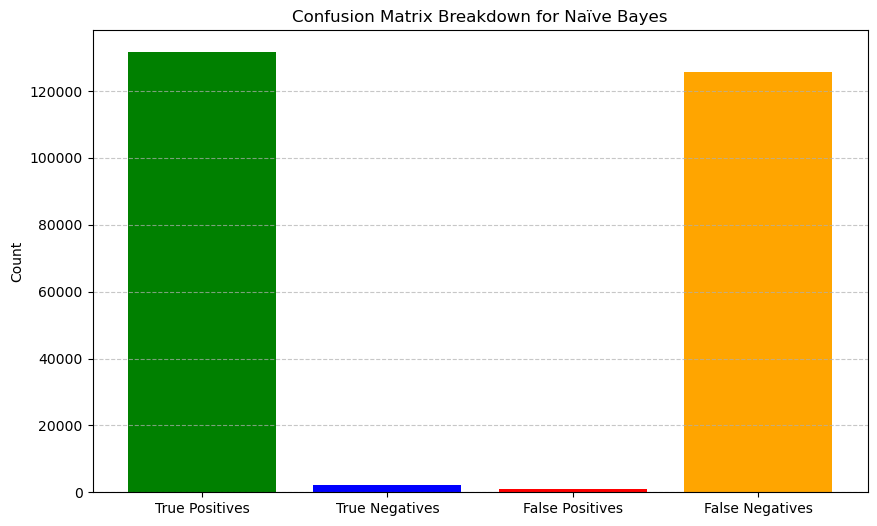

In [207]:
X = df_subset['Numbers'].apply(lambda x: sum(x) if isinstance(x, list) else 0).values.reshape(-1, 1)
y = df_subset['allowed']
nb = GaussianNB()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
nb.fit(X_train_resampled, y_train_resampled)

y_pred = nb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracies = [accuracy_score(y_test, y_pred)]
tp_values = [tp]
tn_values = [tn]
fp_values = [fp]
fn_values = [fn]

print("="*50)
print("Results for Naïve Bayes Classifier")
print("="*50)
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nTrue Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"\nAccuracy: {accuracies[0] * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")

fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
values = [tp, tn, fp, fn]
colors = ['green', 'blue', 'red', 'orange']

ax.bar(metrics, values, color=colors)
ax.set_ylabel("Count")
ax.set_title("Confusion Matrix Breakdown for Naïve Bayes")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
X = df_subset['Numbers'].apply(lambda x: sum(x) if isinstance(x, list) else 0).values.reshape(-1, 1)  # If 'Numbers' is a list, sum them as a feature
y = df_subset['allowed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


accuracies, precisions, recalls, f1_scores = [], [], [], []
tp_values, tn_values, fp_values, fn_values = [], [], [], []

for k in range(1, 13):  
    print("="*50)
    print(f"Results for k={k}")
    print("="*50)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_resampled, y_train_resampled)
    
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for k={k}: {accuracy * 100:.2f}%')
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for k={k}:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nTrue Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    tp_values.append(tp)
    tn_values.append(tn)
    fp_values.append(fp)
    fn_values.append(fn)
    print(f"Precision for k={k}: {precision * 100:.2f}%")
    print(f"Recall for k={k}: {recall * 100:.2f}%")
    print(f"F1 Score for k={k}: {f1_score * 100:.2f}%")
    
    print("\nFirst 5 predictions vs actual values:")
    for i in range(5):
        print(f"Sample {i+1} - Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}")
    
    print("\n" + "="*50 + "\n")
k_values = list(range(1, 13))

fig, axes = plt.subplots(3, 2, figsize=(12, 12)) 

metrics = [
    (tp_values, "True Positives", "green", "o"),
    (tn_values, "True Negatives", "blue", "s"),
    (fp_values, "False Positives", "red", "^"),
    (fn_values, "False Negatives", "orange", "v"),
    (accuracies, "Accuracy", "purple", "D")
]

for i, (values, title, color, marker) in enumerate(metrics):
    row, col = divmod(i, 2) 
    axes[row, col].plot(k_values, values, marker=marker, linestyle="-", color=color, label=title)
    axes[row, col].set_xlabel("k (Number of Neighbors)")
    axes[row, col].set_ylabel("Count" if title != "Accuracy" else "Score")
    axes[row, col].set_title(f"{title} Across Different k Values")
    axes[row, col].grid(True)
    axes[row, col].legend()

fig.delaxes(axes[2, 1])

plt.subplots_adjust(hspace=0.4)
plt.show()

Results for k=1
Accuracy for k=1: 88.07%

Confusion Matrix for k=1:
[[  1190   1903]
 [ 29161 228074]]

True Positives (TP): 228074
True Negatives (TN): 1190
False Positives (FP): 1903
False Negatives (FN): 29161
Precision for k=1: 99.17%
Recall for k=1: 88.66%
F1 Score for k=1: 93.62%

First 5 predictions vs actual values:
Sample 1 - Predicted: 1, Actual: 1
Sample 2 - Predicted: 0, Actual: 1
Sample 3 - Predicted: 1, Actual: 1
Sample 4 - Predicted: 1, Actual: 1
Sample 5 - Predicted: 1, Actual: 1


Results for k=2
Accuracy for k=2: 79.85%

Confusion Matrix for k=2:
[[  1525   1568]
 [ 50898 206337]]

True Positives (TP): 206337
True Negatives (TN): 1525
False Positives (FP): 1568
False Negatives (FN): 50898
Precision for k=2: 99.25%
Recall for k=2: 80.21%
F1 Score for k=2: 88.72%

First 5 predictions vs actual values:
Sample 1 - Predicted: 1, Actual: 1
Sample 2 - Predicted: 0, Actual: 1
Sample 3 - Predicted: 0, Actual: 1
Sample 4 - Predicted: 1, Actual: 1
Sample 5 - Predicted: 1, Actual

In [ ]:
nb.fit(X_train_resampled, y_train_resampled)
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
while True:
    custom_prompt = input("Enter your prompt (or 'exit' to quit): ")
    if custom_prompt.lower() == 'exit':
        break
    elif custom_prompt.strip() == '':
        print("Prompt cannot be empty.")
        continue
    rows = []
    Classprompt = custom_prompt.lower()
    word_classifications = df.set_index('Word').to_dict()
    Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
    Numprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  

    numeric_values = []
    classification_values = []

    for word in re.findall(r'\b\w+\b', Classprompt):  
        word_row = df[df['Word'] == word]
        if word_row.empty:
            classification_value = classify_word(word)  
            numeric_value, interpreted_word = numberify(word)
            new_row = pd.DataFrame({'Word': [word], 'Classification': [classification_value], 
                                    'Number': [numeric_value]})
            df = pd.concat([df, new_row], ignore_index=True)
            
            current_classification = classification_value
            current_numeric_value = numeric_value
        else:
            current_classification = word_row['Classification'].values[0]
            current_numeric_value = word_row['Number'].values[0]
            print(current_classification)
            print(current_numeric_value)
        Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(current_classification), Classprompt)
        Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(current_numeric_value), Numprompt)
    
    print("Processed Classprompt:", Classprompt)
    print("Processed Numprompt:", Numprompt)
    print("Pre Checks")
    Class_3_count = Classprompt.count('3')
    Class_2_count = Classprompt.count('2')
    Class_1_count = Classprompt.count('1')

    Class_Sum_count = Class_3_count + Class_2_count + Class_1_count

    Guess_allowed = 1 
    if Class_3_count > 4 or Class_2_count > 4 or Class_1_count > 4 or Class_Sum_count > 4:
        Guess_allowed = 0

    Numbers = list(map(int, re.findall(r'\d+', Numprompt)))
    Average_Number = sum(Numbers)/len(Numbers) if Numbers else 0

    if Average_Number > 50000000:
        Guess_allowed = 0
    elif any(num > 60000000 for num in Numbers):
        Guess_allowed = 0

    print(f"Filter check allowed: {Guess_allowed}")

    print("running model...")
    def preprocess_custom_prompt(prompt):
        numbers = re.findall(r'\d+', prompt)
    
        numbers = list(map(int, numbers))
        
        sum_of_numbers = sum(numbers) if numbers else 0
        
        sum_of_numbers = max(1, min(sum_of_numbers, 1e8))
        
        return np.array([[sum_of_numbers]])

    X_custom = preprocess_custom_prompt(Numprompt)
    custom_prediction = knn.predict(X_custom)
    print(f"KNN Prediction for the custom prompt: {custom_prediction[0]}")
    NBPredict = nb.predict(X_custom)
    print(f"Naive Bayes Prediction for the custom prompt: {NBPredict[0]}")

In [154]:
notallowed= df_subset[df_subset['allowed']==0].copy()
print(len(notallowed))

10236


In [ ]:
notallowed.head()

In [155]:
allowed=df_subset[df_subset['allowed']==1].head(10236).copy()
print(len(allowed))

10236


In [166]:
allowed.head(15)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,allowed,Classprompt,Numprompt,Class 3 appearance count,Class 2 appearance count,Class 1 appearance count,Class Sum count,Guess allowed,Numbers,Average Number,Banned
0,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\f396d2d6-0668-46d6-833c-6a7da4c1038b.webp'}","goddess portrait, ismail inceoglu",9.119600e+08,50.0,10.0,k_lms,704.0,512.0,d4393f4711a09b71abe9ac39a849b68d70f88ad15b94b0f0b554571bee4e6741,2022-08-20 09:32:00+00:00,0.055936,0.007284,1,0 0 0 0,22220715 22220810 22220600 11110800,0.0,0.0,0.0,0.0,1.0,"[22220715, 22220810, 22220600, 11110800]",1.944323e+07,0
1,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\941d339b-5481-4ee2-b92d-d8a8d2cbfc50.webp'}","goddess portrait, ismail inceoglu",3.614154e+09,50.0,10.0,k_lms,704.0,512.0,d4393f4711a09b71abe9ac39a849b68d70f88ad15b94b0f0b554571bee4e6741,2022-08-20 09:32:00+00:00,0.103962,0.007284,1,0 0 0 0,22220715 22220810 22220600 11110800,0.0,0.0,0.0,0.0,1.0,"[22220715, 22220810, 22220600, 11110800]",1.944323e+07,0
2,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\411fd6fe-8b57-430a-a8f6-60d51a8085d1.webp'}",portrait of king of candy mr harry haribo oil painting bloody conquest tap [ e,2.271109e+09,50.0,7.0,k_lms,512.0,512.0,7c375c633f3ac3961453837abde94580b043b1c2eb5abce4d2c609650b08f08b,2022-08-20 09:33:00+00:00,0.034399,0.022897,1,0 0 0 0 0 0 0 0 0 0 3 3 0 0,22220810 11110200 22220425 11110200 22220510 11110200 33330510 22220600 22220320 22220810 66660675 22220845 33330310 11110100,2.0,0.0,0.0,2.0,0.0,"[22220810, 11110200, 22220425, 11110200, 22220510, 11110200, 33330510, 22220600, 22220320, 22220810, 66660675, 22220845, 33330310, 11110100]",2.380761e+07,0
3,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\6f169011-9809-48a6-9b48-cad6cb07e37f.webp'}",super epic realistic nature photo trending on instagram with lonely person in yellow raincoat standing at a distance,1.947975e+09,50.0,7.0,k_lms,832.0,1024.0,bd227929e003e69eee392c1d8a409445dd790455c1e9bd86ae9e32f4341a874f,2022-08-20 09:34:00+00:00,0.113144,0.001688,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,33330545 22220475 22220945 22220630 22220510 33330825 33330201 22220925 11110410 22220625 22220650 11110200 22220620 22220810 33330825 11110200 11110100 22220825,0.0,0.0,0.0,0.0,1.0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]",2.222057e+07,0
4,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\f88c16f5-5c8c-4427-b50e-2f155204eb11.webp'}",super epic realistic nature photo trending on instagram with lonely person in yellow raincoat standing at a distance,1.035761e+09,50.0,7.0,k_lms,832.0,1024.0,bd227929e003e69eee392c1d8a409445dd790455c1e9bd86ae9e32f4341a874f,2022-08-20 09:34:00+00:00,0.096025,0.001688,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,33330545 22220475 22220945 22220630 22220510 33330825 33330201 22220925 11110410 22220625 22220650 11110200 22220620 22220810 33330825 11110200 11110100 22220825,0.0,0.0,0.0,0.0,1.0,"[33330545, 22220475, 22220945, 22220630, 22220510, 33330825, 33330201, 22220925, 11110410, 22220625, 22220650, 11110200, 22220620, 22220810, 33330825, 11110200, 11110100, 22220825]",2.222057e+07,0
5,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\23791460-0d32-4402-afb8-27ed2c

In [157]:
df_combined = pd.concat([notallowed, allowed], ignore_index=True)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20472 entries, 0 to 20471
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   image                     10695 non-null  object             
 1   prompt                    20472 non-null  object             
 2   seed                      10695 non-null  float64            
 3   step                      10695 non-null  float64            
 4   cfg                       10695 non-null  float32            
 5   sampler                   10695 non-null  object             
 6   width                     10695 non-null  float64            
 7   height                    10695 non-null  float64            
 8   user_name                 10695 non-null  object             
 9   timestamp                 10695 non-null  datetime64[us, UTC]
 10  image_nsfw                20472 non-null  float64            
 11  prompt_nsfw    

In [170]:
df_combined.head(15)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,allowed,Classprompt,Numprompt,Class 3 appearance count,Class 2 appearance count,Class 1 appearance count,Class Sum count,Guess allowed,Numbers,Average Number,Banned
0,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\78b288bb-b04a-4ac2-b466-1749e4c7e5c3.webp'}","portrait of a clown by hr giger, greg rutkowski, luis royo and wayne barlowe, 8 k",6.562743e+08,50.0,7.0,k_lms,512.0,704.0,9e01c31a09dd2acc2061474b9cc95f1813f636332e120a5aa7cf435dda212075,2022-08-20 08:08:00+00:00,0.187132,0.606248,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,22220810 11110200 11110100 22220515 11110200 11110210 22220522 22220415 22220900 22220400 33330420 11110300 22220500 22220700 11110100,0.0,0.0,0.0,0.0,1.0,"[22220810, 11110200, 11110100, 22220515, 11110200, 11110210, 22220522, 22220415, 22220900, 22220400, 33330420, 11110300, 22220500, 22220700, 11110100]",1.851709e+07,1
1,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\5eedb5b2-7da5-40f1-b77d-b8bb3295c2a6.webp'}","portrait of a clown by hr giger, greg rutkowski, luis royo and wayne barlowe, 8 k",4.054062e+09,50.0,7.0,k_lms,512.0,704.0,9e01c31a09dd2acc2061474b9cc95f1813f636332e120a5aa7cf435dda212075,2022-08-20 08:08:00+00:00,0.108867,0.606248,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,22220810 11110200 11110100 22220515 11110200 11110210 22220522 22220415 22220900 22220400 33330420 11110300 22220500 22220700 11110100,0.0,0.0,0.0,0.0,1.0,"[22220810, 11110200, 11110100, 22220515, 11110200, 11110210, 22220522, 22220415, 22220900, 22220400, 33330420, 11110300, 22220500, 22220700, 11110100]",1.851709e+07,1
2,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\dc921dd3-204a-462d-8cb5-34e08bdb51c1.webp'}","portrait of a clown by hr giger, greg rutkowski, luis royo and wayne barlowe, 8 k",1.359984e+09,50.0,7.0,k_lms,512.0,704.0,9e01c31a09dd2acc2061474b9cc95f1813f636332e120a5aa7cf435dda212075,2022-08-20 08:08:00+00:00,0.135886,0.606248,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,22220810 11110200 11110100 22220515 11110200 11110210 22220522 22220415 22220900 22220400 33330420 11110300 22220500 22220700 11110100,0.0,0.0,0.0,0.0,1.0,"[22220810, 11110200, 11110100, 22220515, 11110200, 11110210, 22220522, 22220415, 22220900, 22220400, 33330420, 11110300, 22220500, 22220700, 11110100]",1.851709e+07,1
3,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\5c09e6de-a93c-4822-b703-fb269ece62e4.webp'}","portrait of a clown by hr giger, greg rutkowski, luis royo and wayne barlowe, 8 k",7.654669e+08,50.0,7.0,k_lms,512.0,704.0,9e01c31a09dd2acc2061474b9cc95f1813f636332e120a5aa7cf435dda212075,2022-08-20 08:08:00+00:00,0.128021,0.606248,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,22220810 11110200 11110100 22220515 11110200 11110210 22220522 22220415 22220900 22220400 33330420 11110300 22220500 22220700 11110100,0.0,0.0,0.0,0.0,1.0,"[22220810, 11110200, 11110100, 22220515, 11110200, 11110210, 22220522, 22220415, 22220900, 22220400, 33330420, 11110300, 22220500, 22220700, 11110100]",1.851709e+07,1
4,"{'bytes': None, 'path': 'C:\Users\georg\.cache\huggingface\datasets\downloads\extracted\8b8225f4c51599e99c7d8b471661b86c16f7f7b1d783cb2e9ec11312031ea1aa\76f0a35b-9ff2-48d3-98eb-9e1961db2533.webp'}","portrait of a beautiful female clown by hr giger, greg rutkowski, luis royo and wayne barlowe, 8 k",3.727804e+09,50.0,7.0,k_lms,512.0,704.0,9e01c31a09dd2acc2061474b9cc95f1813f636332e120a5aa7cf435dda212075,2022-08-20 08:11:00+00:00,0.102913,0.815494,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,22220810 11110200 11110100 22220935 22220620 22220515 11110200 11110210 22220522 22220415 22220900 2

Results for Naïve Bayes Classifier

Confusion Matrix:
[[1816 1256]
 [1050 2020]]

True Positives (TP): 2020
True Negatives (TN): 1816
False Positives (FP): 1256
False Negatives (FN): 1050

Accuracy: 62.46%
Precision: 61.66%
Recall: 65.80%
F1 Score: 63.66%


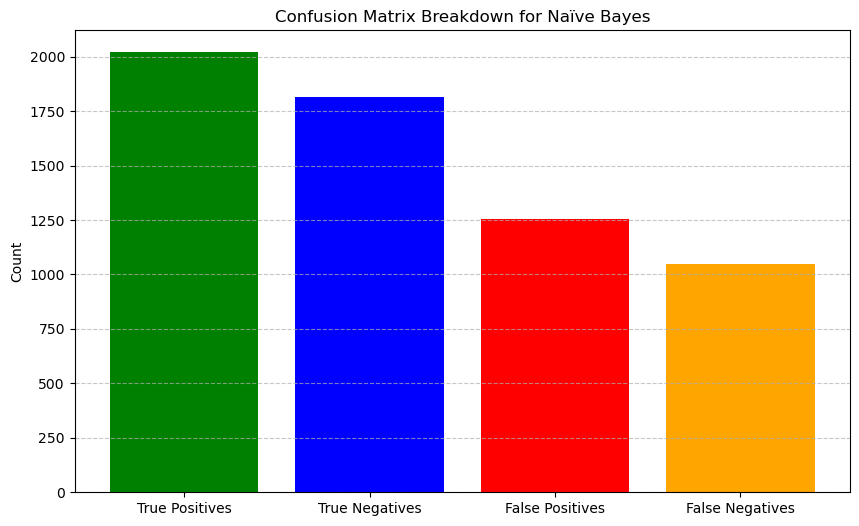

In [176]:
X = df_combined['Numbers'].apply(lambda x: sum(x) if isinstance(x, list) else 0).values.reshape(-1, 1)
y = df_combined['allowed']
nb = GaussianNB()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracies = [accuracy_score(y_test, y_pred)]
tp_values = [tp]
tn_values = [tn]
fp_values = [fp]
fn_values = [fn]

print("="*50)
print("Results for Naïve Bayes Classifier")
print("="*50)
print(f"\nConfusion Matrix:\n{cm}")
print(f"\nTrue Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

precision = tp / (tp + fp) if tp + fp > 0 else 0
recall = tp / (tp + fn) if tp + fn > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

print(f"\nAccuracy: {accuracies[0] * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")

fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
values = [tp, tn, fp, fn]
colors = ['green', 'blue', 'red', 'orange']

ax.bar(metrics, values, color=colors)
ax.set_ylabel("Count")
ax.set_title("Confusion Matrix Breakdown for Naïve Bayes")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Results for k=1
Accuracy for k=1: 88.96%

Confusion Matrix for k=1:
[[2566  506]
 [ 172 2898]]

True Positives (TP): 2898
True Negatives (TN): 2566
False Positives (FP): 506
False Negatives (FN): 172
Precision for k=1: 85.14%
Recall for k=1: 94.40%
F1 Score for k=1: 89.53%

First 5 predictions vs actual values:
Sample 1 - Predicted: 1, Actual: 1
Sample 2 - Predicted: 1, Actual: 1
Sample 3 - Predicted: 1, Actual: 1
Sample 4 - Predicted: 1, Actual: 1
Sample 5 - Predicted: 1, Actual: 1


Results for k=2
Accuracy for k=2: 86.67%

Confusion Matrix for k=2:
[[2663  409]
 [ 410 2660]]

True Positives (TP): 2660
True Negatives (TN): 2663
False Positives (FP): 409
False Negatives (FN): 410
Precision for k=2: 86.67%
Recall for k=2: 86.64%
F1 Score for k=2: 86.66%

First 5 predictions vs actual values:
Sample 1 - Predicted: 1, Actual: 1
Sample 2 - Predicted: 1, Actual: 1
Sample 3 - Predicted: 1, Actual: 1
Sample 4 - Predicted: 1, Actual: 1
Sample 5 - Predicted: 1, Actual: 1


Results for k=3
Accu

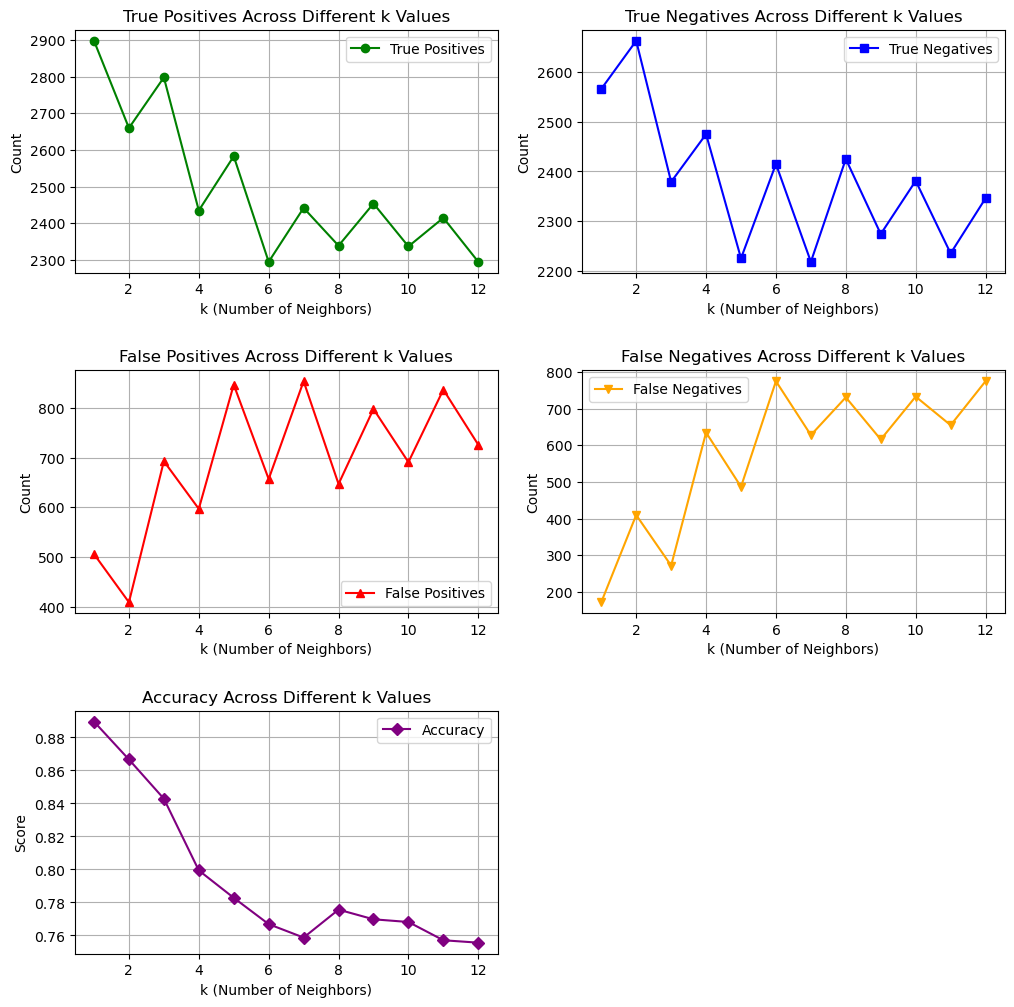

In [159]:
X = df_combined['Numbers'].apply(lambda x: sum(x) if isinstance(x, list) else 0).values.reshape(-1, 1)
y = df_combined['allowed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
accuracies, precisions, recalls, f1_scores = [], [], [], []
tp_values, tn_values, fp_values, fn_values = [], [], [], []

for k in range(1, 13):
    print("="*50)
    print(f"Results for k={k}")
    print("="*50)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for k={k}: {accuracy * 100:.2f}%')
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for k={k}:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nTrue Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    tp_values.append(tp)
    tn_values.append(tn)
    fp_values.append(fp)
    fn_values.append(fn)
    print(f"Precision for k={k}: {precision * 100:.2f}%")
    print(f"Recall for k={k}: {recall * 100:.2f}%")
    print(f"F1 Score for k={k}: {f1_score * 100:.2f}%")
    
    print("\nFirst 5 predictions vs actual values:")
    for i in range(5):
        print(f"Sample {i+1} - Predicted: {y_pred[i]}, Actual: {y_test.iloc[i]}")
    
    print("\n" + "="*50 + "\n")
k_values = list(range(1, 13))

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  
metrics = [
    (tp_values, "True Positives", "green", "o"),
    (tn_values, "True Negatives", "blue", "s"),
    (fp_values, "False Positives", "red", "^"),
    (fn_values, "False Negatives", "orange", "v"),
    (accuracies, "Accuracy", "purple", "D")
]
for i, (values, title, color, marker) in enumerate(metrics):
    row, col = divmod(i, 2) 
    axes[row, col].plot(k_values, values, marker=marker, linestyle="-", color=color, label=title)
    axes[row, col].set_xlabel("k (Number of Neighbors)")
    axes[row, col].set_ylabel("Count" if title != "Accuracy" else "Score")
    axes[row, col].set_title(f"{title} Across Different k Values")
    axes[row, col].grid(True)
    axes[row, col].legend()

fig.delaxes(axes[2, 1])

plt.subplots_adjust(hspace=0.4)
plt.show()

In [173]:
nb.fit(X_train_resampled, y_train_resampled)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
while True:
    custom_prompt = input("Enter your prompt (or 'exit' to quit): ")
    if custom_prompt.lower() == 'exit':
        break
    elif custom_prompt.strip() == '':
        print("Prompt cannot be empty.")
        continue
    rows = []
    Classprompt = custom_prompt.lower()
    word_classifications = df.set_index('Word').to_dict()
    Classprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  
    Numprompt = re.sub(r'[^a-zA-Z\s]', '', Classprompt)  

    numeric_values = []
    classification_values = []

    for word in re.findall(r'\b\w+\b', Classprompt):  
        word_row = df[df['Word'] == word]
        if word_row.empty:
            classification_value = classify_word(word)  
            numeric_value, interpreted_word = numberify(word) 
            new_row = pd.DataFrame({'Word': [word], 'Classification': [classification_value], 
                                    'Number': [numeric_value]})
            df = pd.concat([df, new_row], ignore_index=True)
            
            current_classification = classification_value
            current_numeric_value = numeric_value
        else:
            current_classification = word_row['Classification'].values[0]
            current_numeric_value = word_row['Number'].values[0]
       
        Classprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(current_classification), Classprompt)
        Numprompt = re.sub(r'\b' + re.escape(word) + r'\b', str(current_numeric_value), Numprompt)
    
    Class_3_count = Classprompt.count('3')
    Class_2_count = Classprompt.count('2')
    Class_1_count = Classprompt.count('1')

    Class_Sum_count = Class_3_count + Class_2_count + Class_1_count

    Guess_allowed = 1  
    if Class_3_count > 4 or Class_2_count > 4 or Class_1_count > 4 or Class_Sum_count > 4:
        Guess_allowed = 0

    Numbers = list(map(int, re.findall(r'\d+', Numprompt)))
    Average_Number = sum(Numbers)/len(Numbers) if Numbers else 0

    if Average_Number > 50000000:
        Guess_allowed = 0
    elif any(num > 60000000 for num in Numbers):
        Guess_allowed = 0

    print(f"Filter check allowed: {Guess_allowed}")

    print("running model...")
    def preprocess_custom_prompt(prompt):
        numbers = re.findall(r'\d+', prompt)
    
        numbers = list(map(int, numbers))
        
        sum_of_numbers = sum(numbers) if numbers else 0
        
        sum_of_numbers = max(1, min(sum_of_numbers, 1e8))
        
        return np.array([[sum_of_numbers]])

    X_custom = preprocess_custom_prompt(Numprompt)
    custom_prediction = knn.predict(X_custom)
    print(f"KNN Prediction for the custom prompt: {custom_prediction[0]}")
    NBPredict = nb.predict(X_custom)
    print(f"Naive Bayes Prediction for the custom prompt: {NBPredict[0]}")
    verdict=NBPredict[0]+custom_prediction[0]+Guess_allowed
    if verdict >= 2:
        print("pass!")
    else:
        print("Fail!")

Enter your prompt (or 'exit' to quit):  goddess portrait, ismail inceoglu


Filter check allowed: 1
running model...
KNN Prediction for the custom prompt: 1
Naive Bayes Prediction for the custom prompt: 0
pass!


Enter your prompt (or 'exit' to quit):  portrait of king of candy mr harry haribo oil painting bloody conquest tap [ e


Filter check allowed: 0
running model...
KNN Prediction for the custom prompt: 0
Naive Bayes Prediction for the custom prompt: 0
Fail!


KeyboardInterrupt: Interrupted by user